<a href="https://colab.research.google.com/github/660510745/229352-StatisticalLearning/blob/main/229351_LAB10_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-17 08:44:54--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.005s  

2025-09-17 08:44:54 (27.8 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [3]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [4]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [5]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [6]:
# แบ่งข้อมูลเป็น training set และ test set
train_size = len(data_monthly) - 24
train_data, test_data = data_monthly[0:train_size], data_monthly[train_size:]

print('Training set size:', len(train_data))
print('Test set size:', len(test_data))

Training set size: 235
Test set size: 24


In [25]:
import itertools

trend_types = ['add', 'mul', None]
seasonal_types = ['add', 'mul', None]
damped_options = [True, False]

rmse_results = {}

for trend, seasonal, damped in itertools.product(trend_types, seasonal_types, damped_options):
    if seasonal is None and damped is True:
        continue
    if trend is None and damped is True:
        continue
    if seasonal is None and trend is None:
      continue

    try:
        # Create and fit the model
        model = ExponentialSmoothing(train_data,
                                     trend=trend,
                                     seasonal=seasonal,
                                     seasonal_periods=12,
                                     damped_trend=damped).fit()

        predictions = model.forecast(len(test_data))

        # Calculate RMSE
        model_rmse = rmse(test_data, predictions)

        config_name = f"{trend}_{seasonal}_{'damped' if damped else 'nondamped'}"
        rmse_results[config_name] = model_rmse

    except Exception as e:
        print(f"Error fitting model with trend={trend}, seasonal={seasonal}, damped={damped}: {e}")
        continue

# Print the RMSE for each model configuration
for config, rmse_value in rmse_results.items():
    print(f"Model: {config}, RMSE: {rmse_value}")

# Find the best model configuration (lowest RMSE)
best_config_name = min(rmse_results, key=rmse_results.get)
best_model_rmse = rmse_results[best_config_name]

print(f"\nBest model configuration: {best_config_name}")
print(f"Best model RMSE: {best_model_rmse}")

Model: add_add_damped, RMSE: 1.1134955121933203
Model: add_add_nondamped, RMSE: 1.1669523392712184
Model: add_mul_damped, RMSE: 1.1062443526370112
Model: add_mul_nondamped, RMSE: 1.1639766564724707
Model: add_None_nondamped, RMSE: 2.697261490836458
Model: mul_add_damped, RMSE: 0.8958522762071295
Model: mul_add_nondamped, RMSE: 1.1875960299599877
Model: mul_mul_damped, RMSE: 1.10643357265325
Model: mul_mul_nondamped, RMSE: 1.182446316454671
Model: mul_None_nondamped, RMSE: 3.2472538878024
Model: None_add_nondamped, RMSE: 1.124286066564405
Model: None_mul_nondamped, RMSE: 1.12003424586557

Best model configuration: mul_add_damped
Best model RMSE: 0.8958522762071295


Best model configuration: mul_add_damped


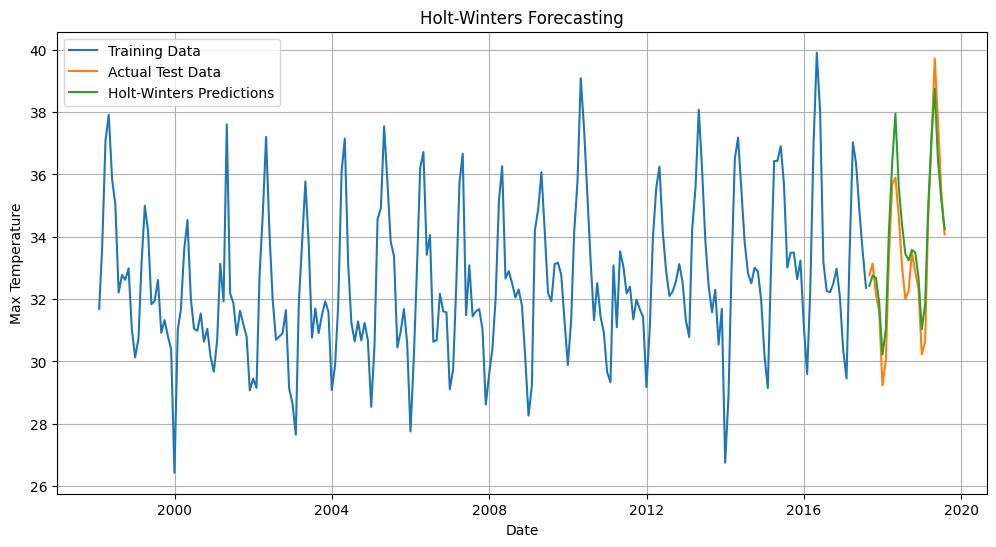

In [24]:
# Identify the best model configuration
best_config_name = min(rmse_results, key=rmse_results.get)
print(f"Best model configuration: {best_config_name}")

parts = best_config_name.split('_')
trend_type = parts[0] if parts[0] != 'None' else None
seasonal_type = parts[1] if parts[1] != 'None' else None
damped = parts[2] == 'damped' if len(parts) > 2 else False

best_model = ExponentialSmoothing(train_data,
                                  trend=trend_type,
                                  seasonal=seasonal_type,
                                  seasonal_periods=12,
                                  damped_trend=damped).fit()

predictions = best_model.forecast(len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions.index, predictions, label='Holt-Winters Predictions')
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.legend()
plt.grid(True)
plt.show()